In [4]:
#|default_exp core
## Standard libraries
import os
import math
import numpy as np
import time
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## project specifics
import diffusion_curvature
from diffusion_curvature.kernels import *
from diffusion_curvature.datasets import *
import jax
import jax.numpy as jnp
jax.devices()

%load_ext autoreload
%autoreload 2

# Implementation (PyGSP + JAX)
> Curvature computations on any graphtools graph

This notebook implements diffusion curvature atop the popular PyGSP library. To compute the curvature of any PyGSP graph, simply instantiate a `DiffusionCurvature` object with your choice of parameters, and pass the graphtools graph through as input.

What follows is a literate implementation, showing the steps of the algorithm applied to our old friend, the torus.

The implementation of Diffusion Curvature involves several big pieces, each of which can be performed with different strategies:

1. Simulating heat diffusion on the manifold, either via powering the diffusion matrix, or by Chebyshev approximation of the heat equation using the graph laplacian.
2. Computing the "spreads" of diffusion. This can be done either via the entropy or the Wasserstein distance.
3. Constructing a comparison space of approximately the same sampling as the input graph.
4. (Experimental) Verification that the above is working by differentiating the spreads of diffusion over time.

We implement everything generically in JAX (a high performance numpy replacement, which can compile to the GPU), treating each of the above as modules that can be parametrically tuned. Functional programming is our game: each function takes a graph object as input and returns an updated graph object with the required quantities computed. 

In [5]:
# Our sample dataset for testing the rest of the notebook
from diffusion_curvature.datasets import torus
X_torus, ks_torus = torus(5000,use_guide_points=True)

# Graph Construction
Our 'Graphs' notebook has code to create PyGSP graphs from pointcloud data, in several varieties. 
We also provide heuristics to sanity check the graphs, as well as choose the optimal parameters.
TODO: MAKE THESE HEURISTICS

In [6]:
from diffusion_curvature.graphs import get_alpha_decay_graph, get_knn_graph, get_scanpy_graph
G_torus = get_alpha_decay_graph(X_torus,knn=15,decay=20,anisotropy=1.0)

# The Diffusion Curvature Class

In [38]:
#| export
import pygsp
import jax
import jax.numpy as jnp
from fastcore.all import *
import skdim
import scipy
from inspect import getfullargspec
from typing import Callable, Literal, get_args, get_origin
import graphtools
from tqdm.auto import trange, tqdm

from jax.experimental import sparse

from diffusion_curvature.graphs import diff_aff, diff_op, diffusion_matrix_from_affinities
from diffusion_curvature.heat_diffusion import heat_diffusion_on_signal, kronecker_delta, jax_power_matrix
from diffusion_curvature.diffusion_laziness import wasserstein_spread_of_diffusion, entropy_of_diffusion
from diffusion_curvature.distances import phate_distances_differentiable
from diffusion_curvature.comparison_space import EuclideanComparisonSpace, fit_comparison_space_model, euclidean_comparison_graph, construct_ndgrid_from_shape, diffusion_coordinates
from diffusion_curvature.clustering import enhanced_spectral_clustering
from diffusion_curvature.normalizing_flows import neural_flattener
from diffusion_curvature.vne import optimal_t_via_vne
from diffusion_curvature.utils import random_jnparray
import diffusion_curvature

import torch

import deepdish

_DIFFUSION_TYPES = Literal['diffusion matrix','heat kernel']
_LAZINESS_METHOD = Literal['Wasserstein','Entropic']
_FLATTENING_METHOD = Literal['Neural', 'Fixed', 'Mean Fixed']
_COMPARISON_METHOD = Literal['Ollivier', 'Subtraction']


class DiffusionCurvature():
    def __init__(
            self,
            diffusion_type:_DIFFUSION_TYPES = 'diffusion matrix', # Either ['diffusion matrix','heat kernel']
            laziness_method: _LAZINESS_METHOD = 'Wasserstein', # Either ['Wasserstein','Entropic']
            flattening_method: _FLATTENING_METHOD = 'Fixed', # Either ['Neural', 'Fixed', 'Mean Fixed']
            comparison_method: _COMPARISON_METHOD = 'Ollivier', # Either ['Ollivier', 'Subtraction']
            dimest = None, # Dimension estimator to use. If none, defaults to kNN.
            points_per_cluster = None, # Number of points to use in each cluster when constructing comparison spaces. Each comparison space takes about 20sec to construct, and has different sampling and dimension. If 1, constructs a different comparison space for each point; if None, constructs just one comparison space.
            comparison_space_size_factor = 1, # Number of points in comparison space is the number of points in the original space divided by this factor.
            use_grid=False, # If True, uses a grid of points as the comparison space. If False, uses a random sample of points.            
            max_flattening_epochs=50,        
    ):
        store_attr()
        self.D = None
        if self.dimest is None:
            self.dimest = skdim.id.KNN()
        if self.flattening_method == "Mean Fixed":
            self.SGT = deepdish.io.load("../data/sgt_peppers_averaged_flat_entropies.h5") # dict of dim x knn x ts containing precomputed flat entropies.

    def unsigned_curvature(
            self,
            G:pygsp.graphs.Graph, # PyGSP input Graph
            t:int, # Scale at which to compute curvature; number of steps of diffusion.
            idx=None, # the index at which to compute curvature. If None, computes for all points. TODO: Implement
            # The below are used internally
            _also_return_first_scale = False, # if True, calculates the laziness measure at both specified t and t=1. The distances (if used) are calcualted with the larger t.
            D = None, # Supply manifold distances yourself to override their computation. Only used with the Wasserstein laziness method.
    ):
        n = G.L.shape[0]
        # Compute diffusion matrix
        match self.diffusion_type:
            case 'diffusion matrix':
                # P = diffusion_matrix_from_affinities(G.K)
                P = diff_op(G).todense() # is sparse, by default
                P = jnp.array(P)
                if t is None: t = optimal_t_via_vne(P)
                Pt = jax_power_matrix(P,t)
            case 'heat kernel':
                signal = jnp.eye(n) if idx is not None else kronecker_delta(n,idx=idx)
                Ps = heat_diffusion_on_signal(G, signal, [1,t])
                P = Ps[0]
                Pt = Ps[1]
            case _:
                raise ValueError(f"Diffusion Type {self.diffusion_type} not in {_DIFFUSION_TYPES}")
        match self.laziness_method:
            case "Wasserstein":
                if D is None: D = phate_distances_differentiable(Pt) #TODO: Could be more efficient here if there's an idx
                print(D[0])
                laziness = wasserstein_spread_of_diffusion(D,Pt) if idx is None else wasserstein_spread_of_diffusion(D[idx],Pt[idx])
                if _also_return_first_scale: laziness_nought = wasserstein_spread_of_diffusion(D,P)
            case "Entropic":
                laziness = entropy_of_diffusion(Pt) if idx is None else entropy_of_diffusion(Pt[idx])
                if _also_return_first_scale: laziness_nought = entropy_of_diffusion(P)
            case _:
                raise ValueError(f"Laziness Method {self.laziness_method} not in {_LAZINESS_METHOD}")
        if _also_return_first_scale: 
            return laziness, laziness_nought, P, Pt, t
        else:
            return laziness
    def curvature(
            self,
            G:pygsp.graphs.Graph, # Input Graph
            t:int, # Scale; if none, finds the knee-point of the spectral entropy curve of the diffusion operator
            idx=None, # the index at which to compute curvature. If None, computes for all points.
            dim = None, # the INTRINSIC dimension of your manifold, as an int for global dimension or list of pointwise dimensions; if none, tries to estimate pointwise.
            knn = 15, # Number of neighbors used in construction of graph;
    ):
        fixed_comparison_cache = {} # if using a fixed comparison space, saves by dimension
        def get_flat_spreads(dimension, jump_of_diffusion, num_points_in_comparison, cluster_idxs, verbose=False):
            match self.flattening_method:
                case "Fixed":
                    if dimension not in fixed_comparison_cache.keys():
                        if self.use_grid:
                            Rn = construct_ndgrid_from_shape(dimension, int(num_points_in_comparison**(1/dimension)))
                        else:
                            Rn = jnp.concatenate([jnp.zeros((1,dim)), 2*random_jnparray(num_points_in_comparison-1, dim)-1])
                        # construct a lattice in dim dimensions of num_points_in_comparison points
                        G = graphtools.Graph(Rn, anisotropy=1, knn=knn, decay=None,).to_pygsp()
                        if self.laziness_method == "Wasserstein": 
                            fixed_comparison_cache[dimension] = (G, scipy.spatial.distance_matrix(Rn,Rn))
                        else: 
                            fixed_comparison_cache[dimension] = (G, None)
                    G_euclidean, D_euclidean = fixed_comparison_cache[dimension]
                    fs = self.unsigned_curvature(G_euclidean,t,idx=0,D=D_euclidean)                    
                    return fs
                case "Kernel Matching":
                    model = EuclideanComparisonSpace(dimension=dimension, num_points=num_points_in_comparison, jump_of_diffusion=jump_of_diffusion,)
                    params = fit_comparison_space_model(model, max_epochs=1000)
                    if verbose: print(params)
                    euclidean_stuffs = model.apply(params) # dictionary containing A, P, D
                    W = fill_diagonal(euclidean_stuffs['A'],0)
                    G_euclidean = pygsp.graphs.Graph(
                        W = W,
                        lap_type = G.lap_type, # type of laplacian; we'll use the same as inputted.
                        )
                    fs = self.unsigned_curvature(G_euclidean,t,idx=0, D=euclidean_stuffs['D'])
                    return fs
                case "Neural":
                    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                    NF = neural_flattener(device=device, max_epochs=self.max_flattening_epochs)
                    # for now, we assume that the neural flattener is only used with single point clusters
                    # TODO: generalize to multiple point clusters by finding centroid
                    distances_to_manfred = jnp.sum(jnp.array(
                        [jnp.linalg.norm(self.diff_coords - self.diff_coords[clustidx],axis=1) for clustidx in cluster_idxs]
                    ),axis=1)
                    idx_closest_to_manfred = jnp.argsort(distances_to_manfred)[:num_points_in_comparison]
                    diff_coords_of_comparison_space = self.diff_coords[idx_closest_to_manfred]
                    flattened_diff_coords = NF.fit_transform(
                        torch.tensor(diff_coords_of_comparison_space.tolist())
                    )
                    # construct graph out of these flattened coordinates
                    G_euclidean = graphtools.Graph(flattened_diff_coords, knn=15, decay=None, anisotropy=1).to_pygsp()
                    fs = self.unsigned_curvature(G_euclidean, t, idx=0)
                    return fs
                    # return G_euclidean, None # TODO: compute diffusion distances
                case "Mean Fixed":
                    dimension_checks_out = dimension in self.SGT.keys()
                    knn_checks_out = knn in self.SGT[dimension].keys()
                    t_checks_out = t in self.SGT[dimension][knn].keys()
                    if not (dimension_checks_out and knn_checks_out and t_checks_out):
                        # compute the old way
                        print("Flat space not precomputed; computing now")
                        self.flattening_method = "Fixed"
                        return get_flat_spreads(
                            dimension = dimension,
                            jump_of_diffusion = jump_of_diffusion,
                            num_points_in_comparison = num_points_in_comparison,
                            cluster_idxs = cluster_idxs,
                            verbose=verbose
                            )
                    else:
                        return self.SGT[dimension][knn][t]
                        

        # Start by estimating the manifold's unsigned curvature, i.e. spreads of diffusion
        manifold_spreads, manifold_spreads_nought, P, Pt, t = self.unsigned_curvature(G,t,idx, _also_return_first_scale=True)

        n = G.L.shape[0]
        if dim is None: # The dimension wasn't supplied; we'll estimate it pointwise
            print("estimating local dimension of each point... may take a while")
            ldims = self.dimest.fit_pw(
                                G.data, #TODO: Currently this requires underlying points!
                                n_neighbors = 100,
                                n_jobs = 1)
            dims_per_point = np.round(ldims.dimension_pw_).astype(int)
        else: # the dimension *was* supplied, but it may be either a single global dimension or a local dimension for each point
            if isinstance(dim, int):
                dims_per_point = jnp.ones(G.P.shape[0], dtype=int)*dim
            else:
                dims_per_point = dim

        if self.flattening_method == "Neural":
            # we need to compute coordinates to flatten. We'll use diffusion maps for this.
            self.diff_coords = diffusion_coordinates(G, t=t)[:,:dim]
        
        flat_spreads = jnp.zeros(n)
        num_points_in_comparison = n // self.comparison_space_size_factor # TODO: Can surely find a better heuristic here
        num_clusters = n // self.points_per_cluster if self.points_per_cluster is not None else 1
        if num_clusters == n: cluster_labels = jnp.arange(n)
        elif idx is not None: 
            cluster_labels = jnp.ones(n) # if a single index is supplied, there's only one cluster.
            cluster_labels = cluster_labels.at[idx].set(0)
            num_clusters = 1
        else: 
            cluster_labels = enhanced_spectral_clustering(G, manifold_spreads, dim=dim, num_clusters=num_clusters, )

        for i in range(num_clusters):
            cluster_idxs = jnp.where(cluster_labels==i)[0]
            average_dim_in_cluster = int(jnp.round(jnp.mean(dims_per_point[cluster_idxs])))
            average_spread_in_cluster = jnp.mean(manifold_spreads_nought[cluster_idxs])
            fs = get_flat_spreads(
                dimension = average_dim_in_cluster,
                jump_of_diffusion = average_spread_in_cluster,
                num_points_in_comparison = num_points_in_comparison,
                cluster_idxs = cluster_idxs,
                verbose=True
                )
            # fs = self.unsigned_curvature(G_euclidean,t,idx=0)
            flat_spreads = flat_spreads.at[cluster_idxs].set(
                    fs
                )
        match self.comparison_method:
            case "Ollivier":
                ks = 1 - manifold_spreads/flat_spreads
            case "Subtraction":
                ks = flat_spreads - manifold_spreads
            case _:
                raise ValueError(f'Comparison method must be in {_COMPARISON_METHOD}')    
        if idx is not None: ks = ks[idx]
        return ks #, flat_spreads, manifold_spreads, P, Pt
    
def fill_diagonal(a, val):
  assert a.ndim >= 2
  i, j = jnp.diag_indices(min(a.shape[-2:]))
  return a.at[..., i, j].set(val)


In [6]:
torch.tensor(jnp.asarray(jnp.argsort(jnp.arange(4))).tolist())

tensor([0, 1, 2, 3])

# Verification

## On the Plane

In [7]:
X_plane = plane(1000)
G_plane = get_alpha_decay_graph(X_plane, decay=None, knn=15, anisotropy=1, )
P = diff_op(G_plane).todense() # is sparse, by default
P = jnp.array(P)
Pt = jax_power_matrix(P,8)

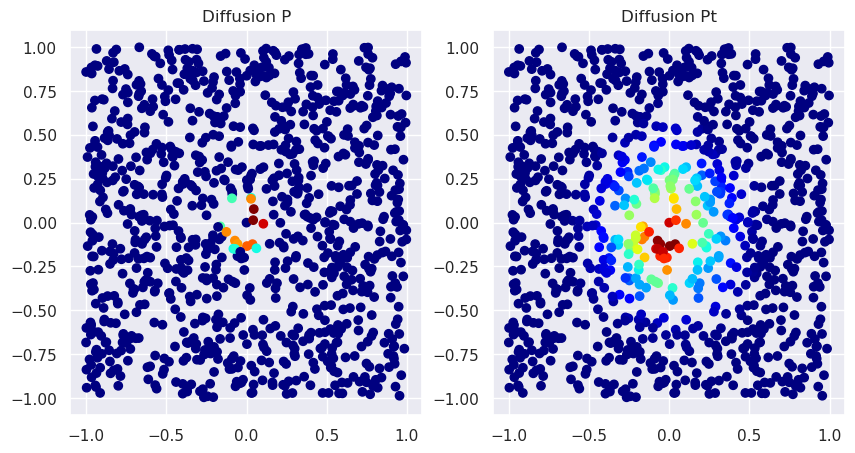

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot the first scatter plot
axs[0].scatter(X_plane[:,0],X_plane[:,1],c=P[0].tolist(), cmap='jet')
axs[0].set_title('Diffusion P')

# plot the second scatter plot
axs[1].scatter(X_plane[:,0],X_plane[:,1],c=Pt[0].tolist(), cmap='jet')
axs[1].set_title('Diffusion Pt')

plt.show()


In [9]:
DC = DiffusionCurvature(laziness_method="Entropic",points_per_cluster=500,comparison_space_size_factor=2,comparison_method="Subtraction", flattening_method="Fixed")
ks_plane= DC.curvature(G_plane, t=8, dim=2, knn=15)

Let's check that higher dimensional planes are also given flat curvature

In [10]:
ds = [3,4,5,6]
planes = [plane(1000*2**(d-2), d) for d in ds]
for i, d in enumerate(ds):
    G = get_alpha_decay_graph(planes[i], decay=None, knn=15, anisotropy=1, )
    DC = DiffusionCurvature(laziness_method="Entropic",points_per_cluster=500,comparison_space_size_factor=1,comparison_method="Subtraction", flattening_method="Fixed")
    ks = DC.curvature(G, t=8, dim=d, knn=15)
    print("dimension",d,": Curvature of Plane is ",ks[0])

dimension 3 : Curvature of Plane is  -0.15057993
dimension 4 : Curvature of Plane is  0.06565571
dimension 5 : Curvature of Plane is  -0.022960186


KeyboardInterrupt: 

In [ ]:
ds = [3,4,5,6]
planes = [plane(1000*2**(d-2), d) for d in ds]
for i, d in enumerate(ds):
    G = get_alpha_decay_graph(planes[i], decay=None, knn=15, anisotropy=1, )
    DC = DiffusionCurvature(laziness_method="Entropic",points_per_cluster=None,comparison_space_size_factor=1,comparison_method="Subtraction", flattening_method="Fixed")
    ks = DC.curvature(G, t=8, dim=d, knn=15)
    print("dimension",d,": Curvature of Plane is ",ks[0])

  0%|          | 0/4 [00:00<?, ?it/s]

dimension 3 : Curvature of Plane is  0.041413307


  0%|          | 0/8 [00:00<?, ?it/s]

dimension 4 : Curvature of Plane is  -0.16898537


  0%|          | 0/16 [00:00<?, ?it/s]

dimension 5 : Curvature of Plane is  0.10107994


  0%|          | 0/32 [00:00<?, ?it/s]

dimension 6 : Curvature of Plane is  0.05217552


## How bout a donut?

### With Fixed Flattening

In [12]:
X_torus,ks = torus(5000,use_guide_points=False)
G_torus = graphtools.Graph(X_torus, anisotropy=1, knn=15, decay=None).to_pygsp()
P = diffusion_matrix_from_affinities(G_torus.K.todense()) # is sparse, by default
P = jnp.array(P)
Pt = jax_power_matrix(P,30)

In [16]:
DC = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    points_per_cluster=None, # construct separate comparison spaces around each point
    comparison_space_size_factor=1
    )
ks_torus = DC.curvature(G_torus, t=30, dim=2, knn=15)

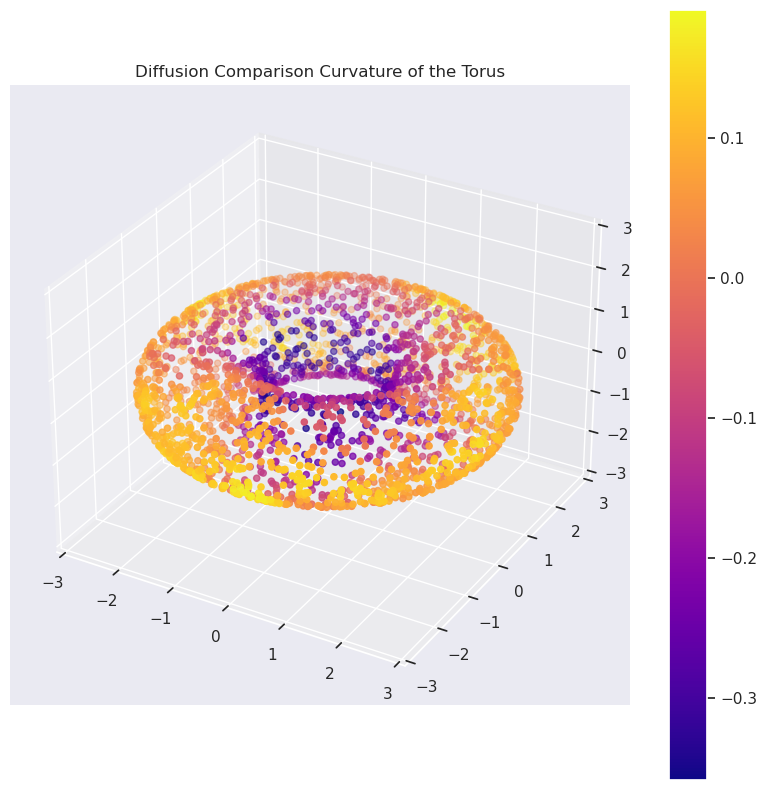

In [17]:
plot_3d(X_torus,ks_torus,colorbar=True,title='Diffusion Comparison Curvature of the Torus')

Text(0, 0.5, 'Diffusion Curvature')

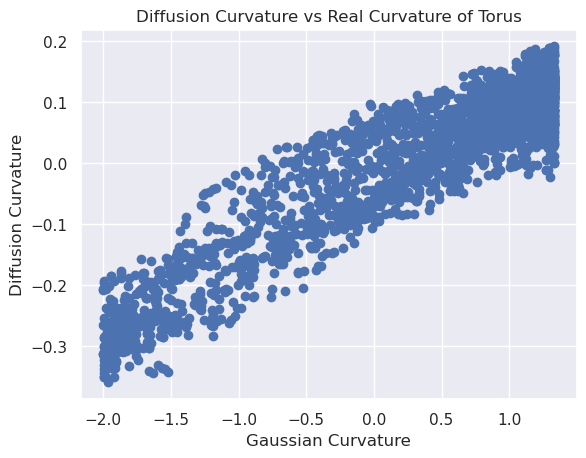

In [18]:
import matplotlib.pyplot as plt
plt.scatter(ks, ks_torus)
plt.title("Diffusion Curvature vs Real Curvature of Torus")
plt.xlabel("Gaussian Curvature")
plt.ylabel("Diffusion Curvature")

### With Grid

In [ ]:
DC = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    points_per_cluster=None, # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    use_grid=True,
    )
ks_torus = DC.curvature(G_torus, t=25, dim=2, knn=15)

  0%|          | 0/1 [00:00<?, ?it/s]

(2500, 2) 49


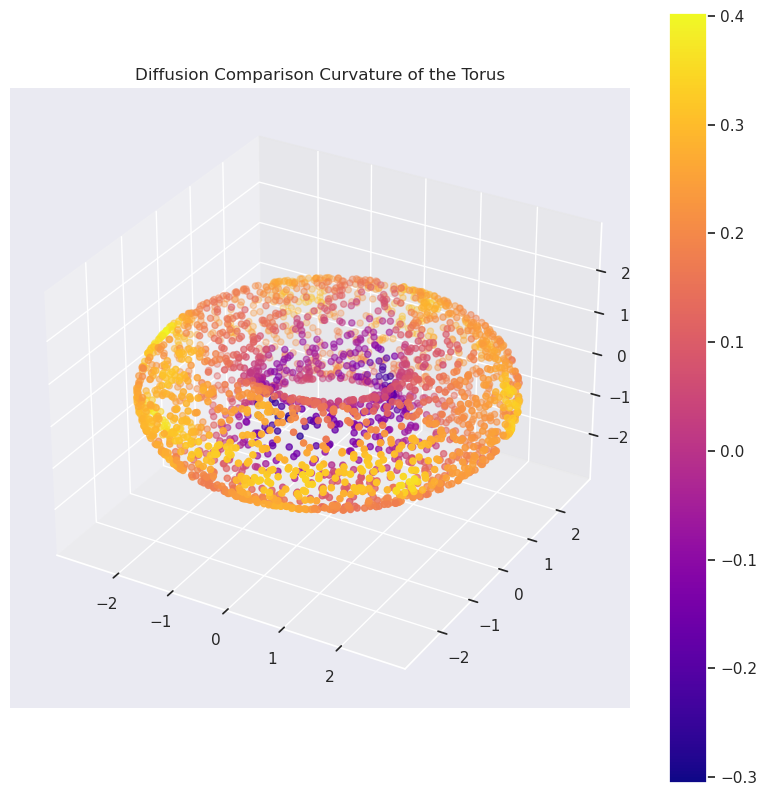

In [ ]:
plot_3d(X_torus,ks_torus,colorbar=True,title='Diffusion Comparison Curvature of the Torus')

Text(0, 0.5, 'Diffusion Curvature')

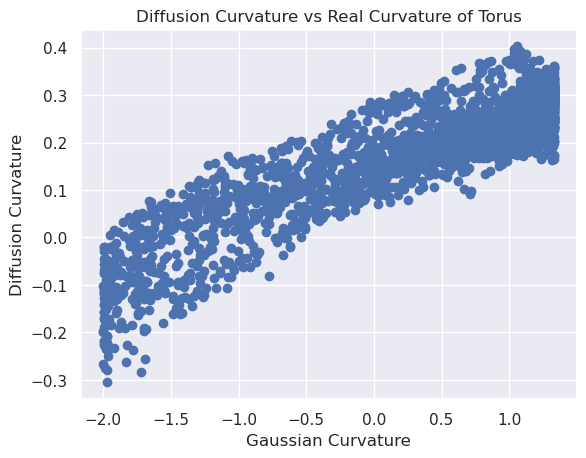

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(ks, ks_torus)
plt.title("Diffusion Curvature vs Real Curvature of Torus")
plt.xlabel("Gaussian Curvature")
plt.ylabel("Diffusion Curvature")

### With Wasserstein

In [ ]:
# DC = DiffusionCurvature(
#     laziness_method="Wasserstein",
#     flattening_method="Fixed",
#     comparison_method="Ollivier",
#     points_per_cluster=None, # construct separate comparison spaces around each point
#     comparison_space_size_factor=1,
#     use_grid=True,
#     )
# ks_torus = DC.curvature(G_torus, t=15, dim=2, knn=15)

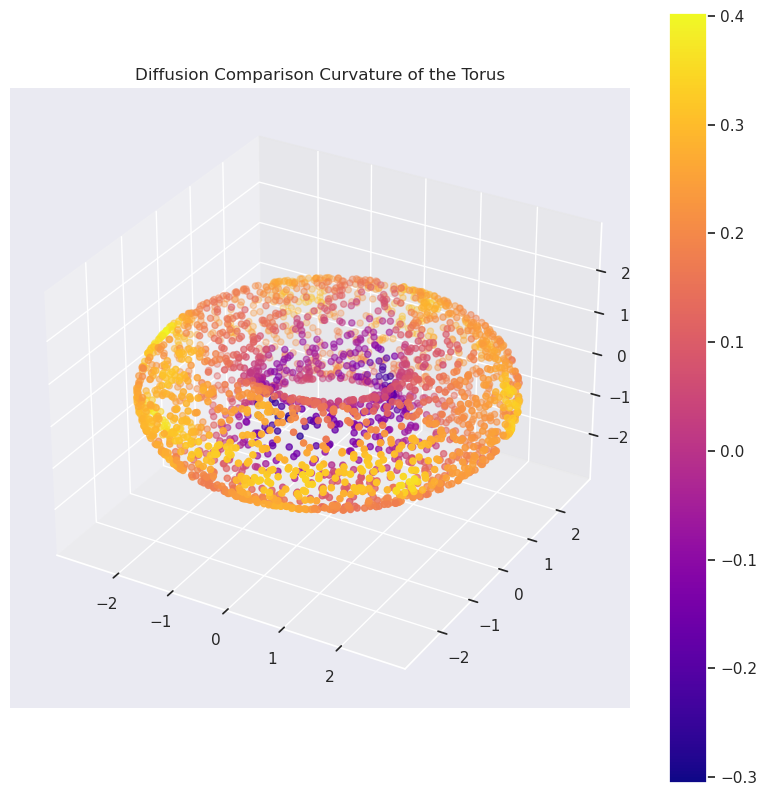

In [ ]:
plot_3d(X_torus,ks_torus,colorbar=True,title='Diffusion Comparison Curvature of the Torus')

Text(0, 0.5, 'Diffusion Curvature')

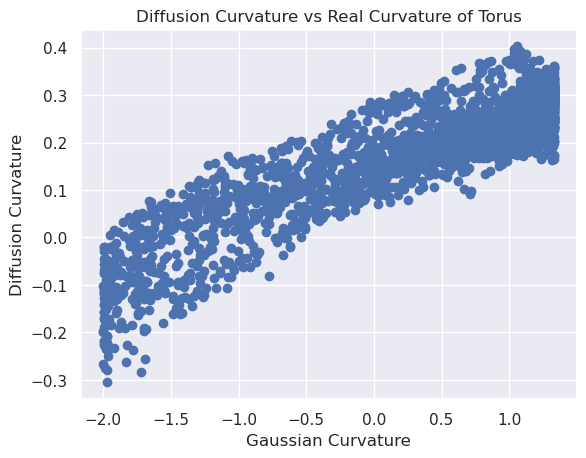

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(ks, ks_torus)
plt.title("Diffusion Curvature vs Real Curvature of Torus")
plt.xlabel("Gaussian Curvature")
plt.ylabel("Diffusion Curvature")

### With VNE t selection

In [ ]:
DC = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    points_per_cluster=None, # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    use_grid=True,
    )
ks_torus = DC.curvature(G_torus, t=None, dim=2, knn=15)

  0%|          | 0/1 [00:00<?, ?it/s]

(2500, 2) 49


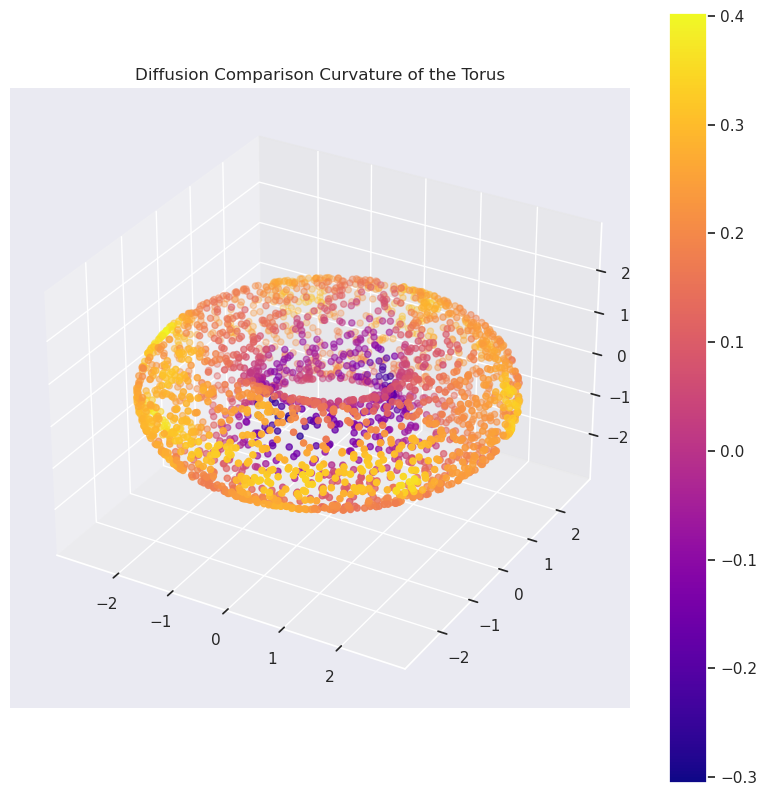

In [ ]:
plot_3d(X_torus,ks_torus,colorbar=True,title='Diffusion Comparison Curvature of the Torus')

Text(0, 0.5, 'Diffusion Curvature')

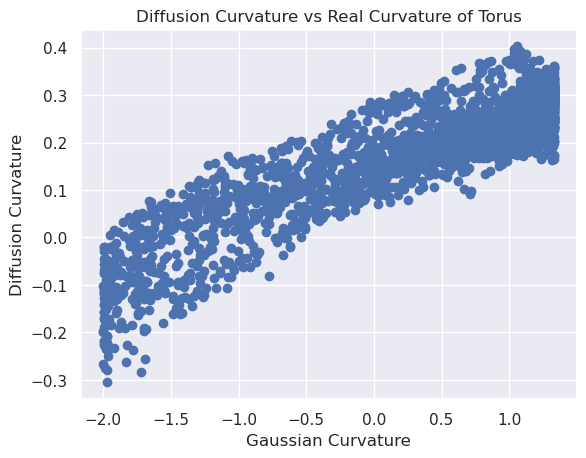

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(ks, ks_torus)
plt.title("Diffusion Curvature vs Real Curvature of Torus")
plt.xlabel("Gaussian Curvature")
plt.ylabel("Diffusion Curvature")

### With Neural Flattening

In [ ]:
DC = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Neural",
    comparison_method="Subtraction",
    points_per_cluster=100, # construct separate comparison spaces around each point
    comparison_space_size_factor=10,
    max_flattening_epochs=100,
    use_grid=False,
    )
ks_torus = DC.curvature(G_torus, t=25, dim=2, knn=15)

  0%|          | 0/24 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144 

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 35.9 K
1 | loss      | NegativeLogLikelihoodQuaUniform | 35.9 K
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
35.9 K    Trainable params
0         Non-trainable params
35.9 K    Total params
0.144     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


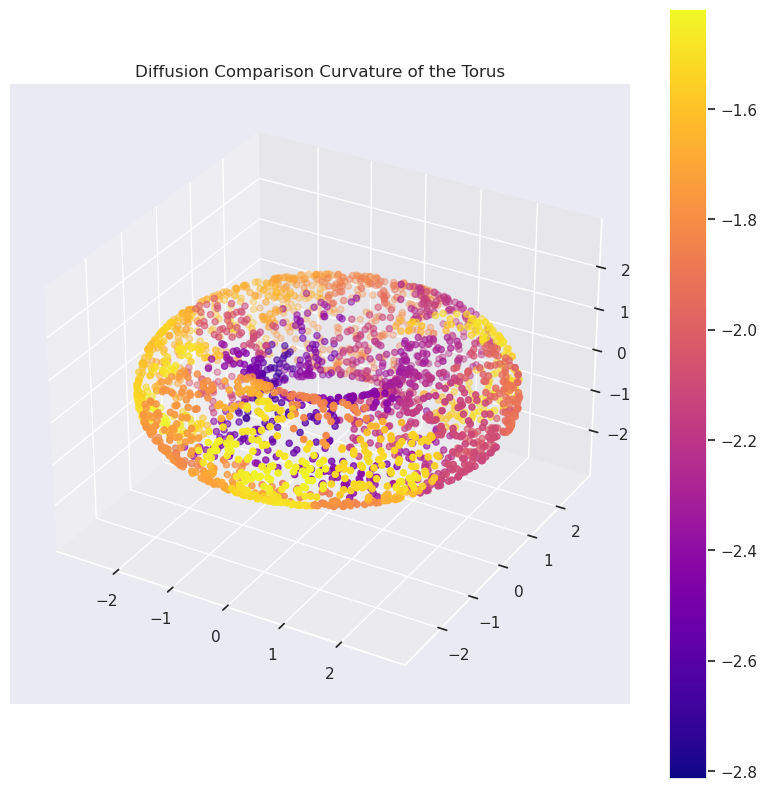

In [ ]:
plot_3d(X_torus,ks_torus,colorbar=True,title='Diffusion Comparison Curvature of the Torus')

Text(0, 0.5, 'Diffusion Curvature')

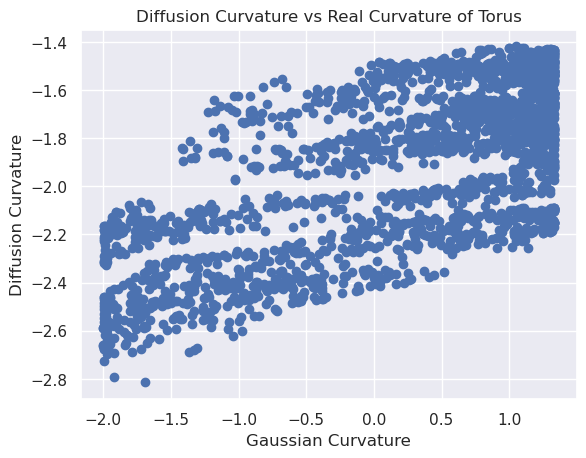

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(ks, ks_torus)
plt.title("Diffusion Curvature vs Real Curvature of Torus")
plt.xlabel("Gaussian Curvature")
plt.ylabel("Diffusion Curvature")

In [ ]:
DC = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    points_per_cluster=None, # construct separate comparison spaces around each point
    comparison_space_size_factor=1
    )
ks_torus_at_idx = DC.curvature(G_torus, t=15, dim=2, knn=15, idx=12)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
ks_torus_at_idx

Array(3.1693997, dtype=float32)

In [ ]:
uks = DC.unsigned_curvature(G_torus,t=15)

In [ ]:
uks

Array([2.5157413, 2.474082 , 2.5332055, ..., 2.6054292, 2.5337448,
       2.5109358], dtype=float32)

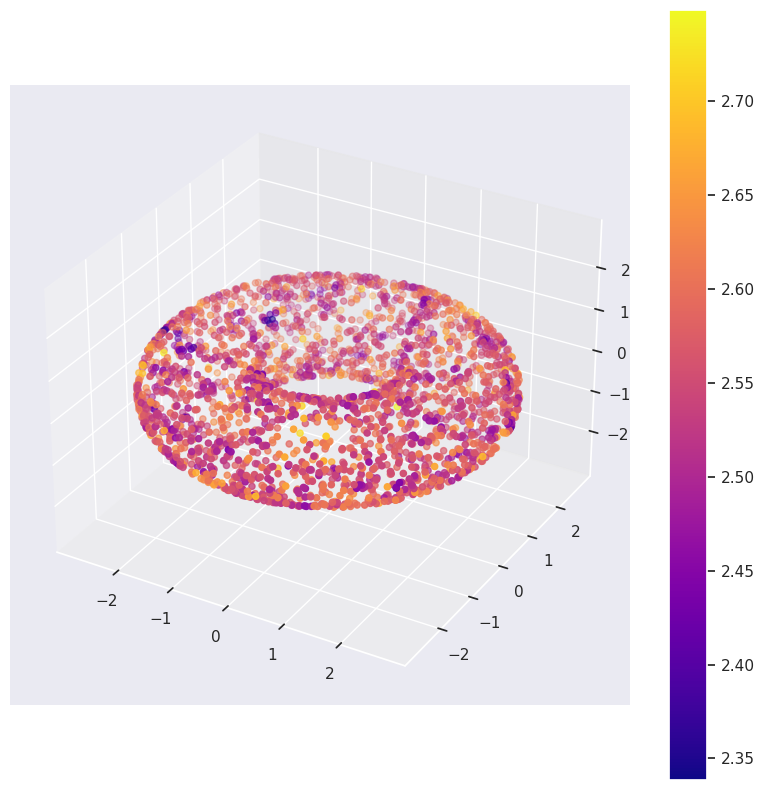

In [ ]:
plot_3d(X_torus,uks,colorbar=True)

In [ ]:
labels = enhanced_spectral_clustering(G_torus, uks, dim=2, num_clusters=9, )

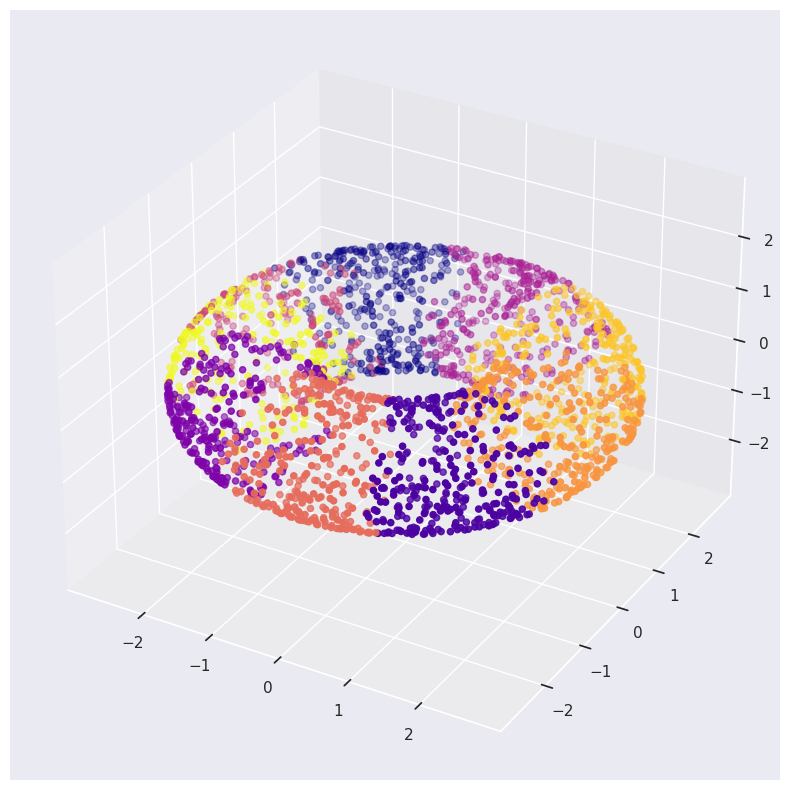

In [ ]:
plot_3d(X_torus,labels)

In [ ]:
entropy_of_diffusion(Pt[0])

Array(6.274018, dtype=float32)

In [ ]:
fakePt = jnp.concatenate([Pt[0], jnp.zeros(len(Pt[0]))])
entropy_of_diffusion(jnp.concatenate([Pt[0], jnp.zeros(len(Pt[0]))]))

Array(6.274018, dtype=float32)

In [ ]:
jax.scipy.special.entr(jnp.concatenate([Pt[0], jnp.zeros(len(Pt[0]))]))

Array([ 0.02743392,  0.00160989,  0.0007063 , ..., -0.        ,
       -0.        , -0.        ], dtype=float32)

In [ ]:
# get num nonzero entries in fakePt
jnp.sum(fakePt>1e-10)

Array(2411, dtype=int32)

In [ ]:
(-jnp.log(1/jnp.sum(fakePt>1e-10, axis=-1)))

Array(7.787797, dtype=float32)

In [ ]:
jnp.sum(jax.scipy.special.entr(jnp.ones(10)/10))

Array(2.302585, dtype=float32)

### With Mean Flattening

In [39]:
DC = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Mean Fixed",
    comparison_method="Subtraction",
    points_per_cluster=None, # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    use_grid=False,
    )
ks_torus = DC.curvature(G_torus, t=25, dim=2, knn=15)

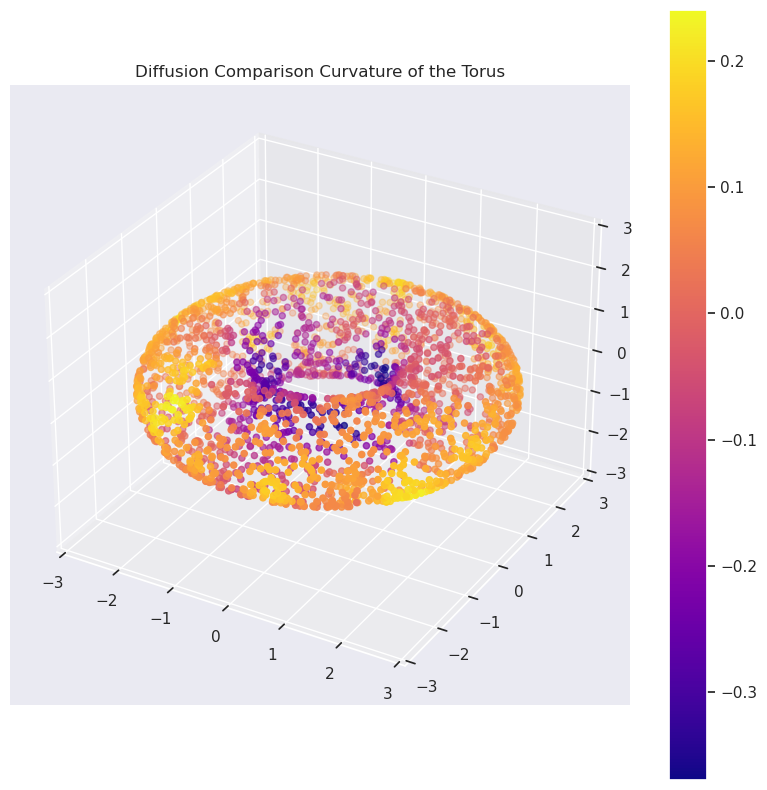

In [40]:
plot_3d(X_torus,ks_torus,colorbar=True,title='Diffusion Comparison Curvature of the Torus')

Text(0, 0.5, 'Diffusion Curvature')

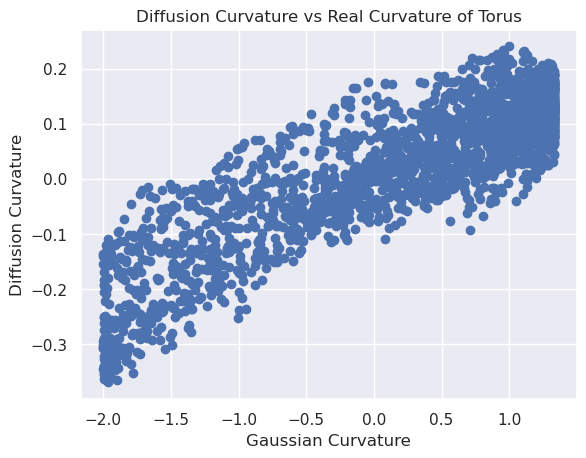

In [41]:
import matplotlib.pyplot as plt
plt.scatter(ks, ks_torus)
plt.title("Diffusion Curvature vs Real Curvature of Torus")
plt.xlabel("Gaussian Curvature")
plt.ylabel("Diffusion Curvature")